In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['inceptionv3', 'inaturalist-2019-fgvc6']


In [2]:
import json


ann_file = '../input/inaturalist-2019-fgvc6/train2019.json'
with open(ann_file) as data_file:
        train_anns = json.load(data_file)

In [3]:
train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']]
train_img_df = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()

,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


In [4]:
print(len(df_train_file_cat))

265213


In [5]:
# splitting data into train and validation
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df_train_file_cat, stratify=df_train_file_cat.category_id, test_size=0.2)

In [6]:
nb_classes = 1010
batch_size = 64
img_size = 299
nb_epochs = 2

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train,
                                                    directory="../input/inaturalist-2019-fgvc6/train_val2019", 
                                                    x_col='file_name', 
                                                    y_col='category_id',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    target_size = (img_size, img_size), 
                                                    color_mode='rgb')     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_dataframe( valid,
                                                          directory="../input/inaturalist-2019-fgvc6/train_val2019", 
                                                          x_col='file_name', 
                                                          y_col='category_id',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical', 
                                                          target_size = (img_size, img_size), 
                                                          color_mode='rgb')

Found 212170 images belonging to 1010 classes.
Found 53043 images belonging to 1010 classes.


In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Model
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (img_size, img_size, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable = True
for layer in pre_trained_model.layers:
  if layer.name == 'mixed6':
    break
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Instructions for updating:
Colocations handled automatically by placer.
last layer output shape:  (None, 17, 17, 768)


In [9]:
# Check the trainable status of the individual layers
for layer in pre_trained_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f229e63aa90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f229e63ae48> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7f229e623dd8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f229e642240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f229e6425c0> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7f229de19a20> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f229de19e48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f229e5a95f8> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7f229e5a97b8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f229e666780> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f229e5c2e80> False
<tensorflow.python.keras.layers.conv

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(rate=0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (nb_classes, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
history = model.fit_generator(train_generator, epochs=nb_epochs, validation_data = validation_generator, verbose = 1)

model.save("rps.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
3316/3316 [==============================] - 10756s 3s/step - loss: 4.7118 - acc: 0.1260 - val_loss: 3.9689 - val_acc: 0.2144
Epoch 2/2
3316/3316 [==============================] - 10862s 3s/step - loss: 3.5791 - acc: 0.2419 - val_loss: 3.9385 - val_acc: 0.2459


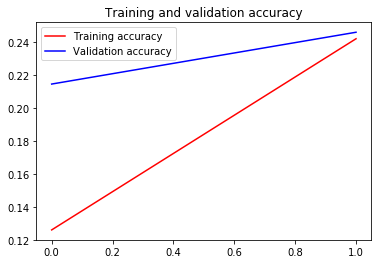

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()